# Predictive model

_In this Notebook we will present the way we computed the distribution of the arrival delays. Each assumption made will be followed by its justification and the reasons behind it ._

In [1]:
%%configure
{"conf": {
    "spark.app.name": "group100_final"
}}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
9204,application_1589299642358_3771,pyspark,idle,Link,Link,
9205,application_1589299642358_3772,pyspark,idle,Link,Link,
9216,application_1589299642358_3783,pyspark,idle,Link,Link,
9217,application_1589299642358_3784,pyspark,idle,Link,Link,
9226,application_1589299642358_3793,pyspark,busy,Link,Link,
9230,application_1589299642358_3797,pyspark,idle,Link,Link,
9236,application_1589299642358_3804,pyspark,idle,Link,Link,
9237,application_1589299642358_3805,pyspark,idle,Link,Link,
9239,application_1589299642358_3808,pyspark,busy,Link,Link,
9244,application_1589299642358_3813,pyspark,idle,Link,Link,


### Start Spark

In [2]:
# Initialization

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
9273,application_1589299642358_3844,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
username = 'mjouve'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
import pandas as pd
import numpy as np

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import datetime
import geopy.distance

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
sbb = spark.read.orc('/data/sbb/orc/istdaten')
stops = spark.read.orc('/data/sbb/timetables/orc/stops/')
stop_times = spark.read.csv('/data/sbb/timetables/csv/stop_times/2019/05/14/stop_times.txt', sep=',', header=True)
trips = spark.read.orc('/data/sbb/timetables/orc/trips')
calendar = spark.read.orc('/data/sbb/timetables/orc/calendar')
routes = spark.read.orc('/data/sbb/timetables/orc/routes')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
sbb_en = sbb.select(
          sbb['BETRIEBSTAG'].alias('date'), 
          sbb['FAHRT_BEZEICHNER'].alias('id'), 
          sbb['PRODUKT_ID'].alias('transport'), 
          sbb['LINIEN_ID'].alias('train_number'), 
          sbb['HALTESTELLEN_NAME'].alias('stop_name'), 
          sbb['ANKUNFTSZEIT'].alias('arrival_time'), 
          sbb['AN_PROGNOSE'].alias('actual_arrival_time'),
          sbb['AN_PROGNOSE_STATUS'].alias('status_arrival_time'),
          sbb['ABFAHRTSZEIT'].alias('departure_time'),
          sbb['AB_PROGNOSE'].alias('actual_departure_time'),
          sbb['AB_PROGNOSE_STATUS'].alias('status_departure_time'),
          sbb['DURCHFAHRT_TF'].alias('does_not_stop_here'),
          sbb['bpuic'].alias('stop_id'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
sbb_en.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------------+---------+------------+------------+------------+-------------------+-------------------+----------------+---------------------+---------------------+------------------+-------+
|      date|                 id|transport|train_number|   stop_name|arrival_time|actual_arrival_time|status_arrival_time|  departure_time|actual_departure_time|status_departure_time|does_not_stop_here|stop_id|
+----------+-------------------+---------+------------+------------+------------+-------------------+-------------------+----------------+---------------------+---------------------+------------------+-------+
|03.09.2018|80:06____:17010:000|      Zug|       17010|Basel Bad Bf|            |                   |           PROGNOSE|03.09.2018 05:45|                     |            UNBEKANNT|             false|8500090|
+----------+-------------------+---------+------------+------------+------------+-------------------+-------------------+----------------+---------------------+

`zurich_stops`: contains the stops close to zurich (less than 15 Km)

In [10]:
zurich_stops = spark.read.orc("/user/{}/zurich_stops.orc".format(username)).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

`sbb_zurich`: joins the data from sbb with the one in zurich_stops based on stop_id

In [11]:
sbb_zurich = zurich_stops.join(sbb_en, on='stop_id')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

_These are the possible status._

In [15]:
sbb_zurich.select('status_departure_time').dropDuplicates().show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+
|status_departure_time|
+---------------------+
|           GESCHAETZT|
|                 null|
|             PROGNOSE|
|                 REAL|
|            UNBEKANNT|
+---------------------+

_Let's see how many stops have `REAL` and `GESCHAETZT` data._

In [25]:
test = sbb_zurich.filter((sbb_zurich.status_arrival_time == 'GESCHAETZT') | (sbb_zurich.status_arrival_time == 'REAL')).select('stop_id')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
test.dropDuplicates().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

114

_If we add the `PROGNOSE` status (non-null and non_empty), let's see how many stops data we would have._

In [49]:
test2 = sbb_zurich.filter((sbb_zurich.status_arrival_time == 'PROGNOSE') 
                          & (sbb_zurich.actual_arrival_time.isNotNull())
                          & (sbb_zurich.actual_arrival_time != "") 
                          & (sbb_zurich.arrival_time != "") ).select(['arrival_time', 'actual_arrival_time', 'stop_id'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
test2.dropDuplicates().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1497

***So because the status REAL and GESCHAETZT fail to cover the majority of the stop_id (close to zurich) only 114 out of 1584 , we decided to consider the data havin PROGNOSE as status to take full advantage from the real data provided by sbb.***

In [13]:
zurich_sbb_filtered = sbb_zurich.filter(((sbb_zurich.status_arrival_time == 'PROGNOSE') 
                                        | (sbb_zurich.status_arrival_time == 'GESCHAETZT')
                                        | (sbb_zurich.status_arrival_time == 'REAL'))
                                        & (sbb_zurich.actual_arrival_time.isNotNull())
                                        & (sbb_zurich.arrival_time.isNotNull())
                                        & (sbb_zurich.actual_arrival_time != "") 
                                        & (sbb_zurich.arrival_time != "") )\
                                .select(['stop_id', 'date', 'id', 'arrival_time', 'actual_arrival_time', 'status_arrival_time'])\
                                .cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
zurich_sbb_filtered.show(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+------------+----------------+-------------------+-------------------+
|stop_id|      date|          id|    arrival_time|actual_arrival_time|status_arrival_time|
+-------+----------+------------+----------------+-------------------+-------------------+
|8503000|03.09.2018|85:11:10:002|03.09.2018 21:51|03.09.2018 21:53:40|               REAL|
|8503000|03.09.2018|85:11:12:001|03.09.2018 10:51|03.09.2018 10:51:28|               REAL|
+-------+----------+------------+----------------+-------------------+-------------------+
only showing top 2 rows

In [15]:
# compute the departure and arrival delays
format_actual = "dd.MM.yyyy HH:mm:ss"
format_arrival = "dd.MM.yyyy HH:mm"

arrival_delay = (F.unix_timestamp('actual_arrival_time', format_actual) - 
        F.unix_timestamp('arrival_time', format_arrival))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
def get_week_day(date):
    '''
    Extracts the day of the week , useful to use data taken from working days only
    '''
    converted_date = datetime.datetime.strptime(str(date), "%d.%m.%Y")
    return converted_date.weekday()

week_day_udf = F.udf(get_week_day, IntegerType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
date = F.to_date('date', 'dd.MM.yyyy')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
sbb_zurich_delay = zurich_sbb_filtered.withColumn("arrival_delay", arrival_delay)
sbb_zurich_day = sbb_zurich_delay.withColumn("day_week", week_day_udf(F.split(sbb_zurich_delay.arrival_time, " ")[0]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
sbb_zurich_day.describe('arrival_delay').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+
|summary|    arrival_delay|
+-------+-----------------+
|  count|        203990527|
|   mean|76.38770603793773|
| stddev|261.4883160266222|
|    min|           -86580|
|    max|            83893|
+-------+-----------------+

***Looking at the stats of the arrival delays we decided to filter out delays +- 15mins (aprox 1000 secondes).***

In [21]:
sbb_zurich_without_outliers = sbb_zurich_day.filter((sbb_zurich_day['arrival_delay'] > -1000) &
                                       (sbb_zurich_day['arrival_delay'] < 1000))
                                      

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
sbb_zurich_without_outliers.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+------------+----------------+-------------------+-------------------+-------------+--------+
|stop_id|      date|          id|    arrival_time|actual_arrival_time|status_arrival_time|arrival_delay|day_week|
+-------+----------+------------+----------------+-------------------+-------------------+-------------+--------+
|8503000|03.09.2018|85:11:10:002|03.09.2018 21:51|03.09.2018 21:53:40|               REAL|          160|       0|
+-------+----------+------------+----------------+-------------------+-------------------+-------------+--------+
only showing top 1 row

***We filter out data for sundays and saturdays as we only consider business days.***

In [16]:
sbb_zurich_weekday = sbb_zurich_without_outliers.filter(sbb_zurich_without_outliers.day_week.isin([0,1,2,3,4]))

sbb_zurich_weekday = sbb_zurich_weekday.drop("day_week")
sbb_zurich_weekday = sbb_zurich_weekday.drop("status_arrival_time")
sbb_zurich_weekday = sbb_zurich_weekday.drop("actual_arrival_time")
sbb_zurich_weekday = sbb_zurich_weekday.drop('date').cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
sbb_zurich_weekday.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+----------------+-------------+
|stop_id|          id|    arrival_time|arrival_delay|
+-------+------------+----------------+-------------+
|8503000|85:11:10:002|03.09.2018 21:51|          160|
+-------+------------+----------------+-------------+
only showing top 1 row

In [19]:
@udf
def get_time(date):
    """
    Discards the date and keep only the time 
    """
    return date.split(' ')[-1]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
sbb_zurich_arrival = sbb_zurich_weekday.withColumn('arrival_time_2', get_time(sbb_zurich_weekday.arrival_time))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
sbb_zurich_arrival.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+----------------+-------------+--------------+
|stop_id|          id|    arrival_time|arrival_delay|arrival_time_2|
+-------+------------+----------------+-------------+--------------+
|8503000|85:11:10:002|03.09.2018 21:51|          160|         21:51|
+-------+------------+----------------+-------------+--------------+
only showing top 1 row

In [27]:
sbb_zurich_arrival_final = sbb_zurich_arrival.drop('arrival_time').drop('id').withColumnRenamed('arrival_time_2', 'arrival_time')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

`sbb_zurich_arrival_final`: This is what we will keep from tha sbb data (stop_id, arrival_time, arrival_delay) tuples.

In [28]:
sbb_zurich_arrival_final.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+------------+
|stop_id|arrival_delay|arrival_time|
+-------+-------------+------------+
|8503000|          160|       21:51|
+-------+-------------+------------+
only showing top 1 row

In [29]:
#sbb_zurich_arrival_final.write.format("orc").mode("overwrite").save("/user/{}/zurich_delays.orc".format('mjouve'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Loading previous dataframe

In [30]:
sbb_zurich = spark.read.orc("/user/{}/zurich_delays.orc".format(username)).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**We groupby stop_id and arrival_time and collect their respective delays in the arrival_delays list**

In [32]:
grouped_delay = sbb_zurich.groupby('stop_id','arrival_time')\
                           .agg(F.collect_list('arrival_delay').alias('arrival_delays'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# already save
#grouped_delay.write.format("orc").mode("overwrite").save("/user/{}/grouped_delays.orc".format('mjouve'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Loading previous dataframe

_`grouped_delay`: each couple (stop_id,arrival_time) with their list of delays over working days for 2 years._

In [7]:
grouped_delay = spark.read.orc("/user/{}/grouped_delays.orc".format(username)).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
grouped_delay.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+--------------------+
|stop_id|arrival_time|      arrival_delays|
+-------+------------+--------------------+
|8502186|       20:50|[70, 77, 79, 61, ...|
|8502188|       11:08|[26, 26, -19, 3, ...|
|8502188|       12:23|[48, 66, 78, 64, ...|
|8502220|       03:36|          [178, 206]|
|8502220|       23:09|[76, 58, 134, 55,...|
+-------+------------+--------------------+
only showing top 5 rows

In [8]:
grouped_delay.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

541989

# Finding a distribution for the delays

_We will explore the different delays to gain insight about their distribution._

In [9]:
truncated_delays = grouped_delay.limit(200000)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
from pyspark.sql.types import IntegerType ,  ArrayType
def truncate_delays(lis):
    """
    transform the delays to multiples of ten for better visulatisation of the delays frequency
    """
    dizaines = [x - (x%10) for x in lis]
    return dizaines
    
udf_truncate_delays = udf(truncate_delays, ArrayType(IntegerType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
truncated_delays = truncated_delays.withColumn("arrival_delays_trunc", udf_truncate_delays("arrival_delays"))\
                   .drop('arrival_delays')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
truncated_delays.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+--------------------+
|stop_id|arrival_time|arrival_delays_trunc|
+-------+------------+--------------------+
|8502186|       20:50|[70, 70, 70, 60, ...|
|8502188|       11:08|[20, 20, -20, 0, ...|
|8502188|       12:23|[40, 60, 70, 60, ...|
|8502220|       03:36|          [170, 200]|
|8502220|       23:09|[70, 50, 130, 50,...|
+-------+------------+--------------------+
only showing top 5 rows

In [13]:
# truncated_delays.write.format("orc").mode("overwrite").save("/user/{}/truncated_delays.orc".format('mjouve'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# truncated_delays = spark.read.orc("/user/{}/truncated_delays.orc".format('mjouve')).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
from pyspark.sql.functions import explode

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
truncated_delays_exploded = truncated_delays.select(truncated_delays.stop_id , truncated_delays.arrival_time ,\
                            explode(truncated_delays.arrival_delays_trunc)).withColumnRenamed('col', 'delay')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
truncated_delays_exploded.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+-----+
|stop_id|arrival_time|delay|
+-------+------------+-----+
|8502186|       20:50|   70|
|8502186|       20:50|   70|
|8502186|       20:50|   70|
|8502186|       20:50|   60|
|8502186|       20:50|   70|
+-------+------------+-----+
only showing top 5 rows

In [18]:
#t runcated_delays_exploded.write.format("orc").mode("overwrite").save("/user/{}/truncated_delays_exploded.orc".format('mjouve'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# truncated_delays_exploded = spark.read.orc("/user/{}/truncated_delays_exploded.orc".format('mjouve')).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
delay_frequency = truncated_delays_exploded.groupby('delay').agg(F.count('stop_id').alias('count'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
delay_frequency.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+
|delay|  count|
+-----+-------+
|  540|  13019|
| -590|    166|
|  580|   9772|
|  970|   1482|
|  -20|1104213|
+-----+-------+
only showing top 5 rows

In [23]:
# delay_frequency.write.format("orc").mode("overwrite").save("/user/{}/delay_frequency.orc".format('mjouve'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Loading the delays frequency dataframe

In [24]:
delay_frequency = spark.read.orc("/user/{}/delay_frequency.orc".format('mjouve')).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
delay_frequency_filtered1 = delay_frequency.filter(delay_frequency.delay > -30).filter(delay_frequency.delay < 400)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
%%spark -o delay_frequency_filtered1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

_We will now plots the frequency of some delays to gain insight._

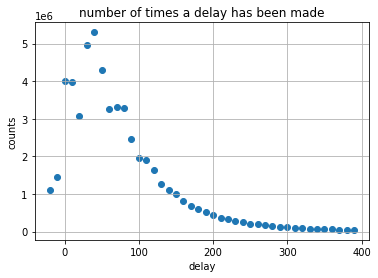

In [35]:
%%local
import matplotlib.pyplot as plt
import numpy as np
x = delay_frequency_filtered1['delay'].tolist()
y = delay_frequency_filtered1['count'].tolist()
plt.scatter(x,y)
plt.xlabel('delay')
plt.ylabel('counts')
plt.title('number of times a delay has been made')
plt.grid()

***This plot gave us some background regarding the delays distribution to choose. In fact, our delays are following an exponential distribution that we have to estimate its parameter lambda that represents it the best. \
Using the maximum likelihood estimation we find a formulae for this lambda. It is equal to the inverse of mean of the delays.\
Hence for each (stop_id/arrial_time) we compute its distribution's parameter to use it later to compute the proability of catching next connexion.***\
***We assumed these distributions between different stops/arrival_times to be uncorrelated.***

In [39]:
from pyspark.sql.types import StringType , FloatType , IntegerType ,  ArrayType

def add_zero(s):
    """
    we add ':00' for arrival_time column to match the arrival_time in stop_times
    """
    return s+":00"
udf_add_zero = udf(add_zero, StringType())

def compute_lambda(delays):
    """
    Computes lambda of exponential distribution using the maximum likelihood estimation
    """
    n = float(len(delays))
    total = sum(int(i) for i in delays)
    if total == 0: return -9999 # to change with median #when getting lambda of stop/arrival check if it is -9999
    else: return n/total # if so take probability 1
udf_compute_lambda = udf(compute_lambda, FloatType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
grouped_delay_lambdas = grouped_delay.withColumn("arrival_time_zero", udf_add_zero("arrival_time")).drop('arrival_time').withColumnRenamed('arrival_time_zero', 'arrival_time')
grouped_delay_lambdas = grouped_delay_lambdas[['stop_id','arrival_time','arrival_delays']]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

`grouped_delay_lambdas`: Using the arrival_delays we compute the lambda for each (stop_id/arrival_time) couple

In [41]:
grouped_delay_lambdas = grouped_delay_lambdas.withColumn("lambda", udf_compute_lambda("arrival_delays"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#grouped_delay_lambdas.write.format("orc").mode("overwrite").save("/user/{}/grouped_delay_lambdas.orc".format('mjouve'))

In [43]:
grouped_delay_lambdas = spark.read.orc("/user/{}/grouped_delay_lambdas.orc".format('mjouve')).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
grouped_delay_lambdas.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+--------------------+------------+
|stop_id|arrival_time|      arrival_delays|      lambda|
+-------+------------+--------------------+------------+
|8502186|    20:50:00|[70, 77, 79, 61, ...| 0.012391099|
|8502188|    11:08:00|[26, 26, -19, 3, ...| 0.031403214|
|8502188|    12:23:00|[48, 66, 78, 64, ...| 0.016922282|
|8502220|    03:36:00|          [178, 206]|0.0052083335|
|8502220|    23:09:00|[76, 58, 134, 55,...| 0.013511314|
+-------+------------+--------------------+------------+
only showing top 5 rows

***As stated in the beginning some stop_id could not be found in the sbb data so we decided to assign for these stops a lambda value equals to the mean of all lambdas.***

In [44]:
grouped_delay_lambdas.agg({'lambda' : 'mean'}).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|         avg(lambda)|
+--------------------+
|0.023447352748076224|
+--------------------+

# Next step:

_Now that we have a good predictive model, we can build our final route planning algorithm. You can see the result of the algorithm that takes as input the departure time in the `route_planning_final.ipynb` notebook or the algorithm that takes as input the desired arrival time in `final_algorithm.ipynb`. For the later, there are also some tests._